In [9]:
import logging

import sep
import pickle

import numpy as np
from scipy import ndimage

from PIL import Image

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

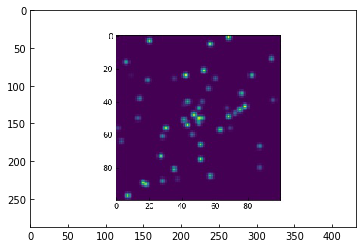

In [10]:
fake1 = ("fake1.jpeg")
img1 = Image.open(fake1)
data = np.array(img1)
data1 = np.save( fake1 + '.npz', data)
plt.imshow(img1)

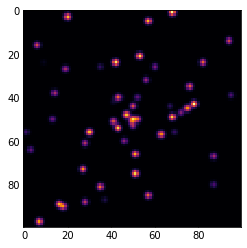

In [11]:
img1 = np.load("fake1.npy")
plt.imshow(img1)

In [12]:
data2 = np.load("fake1.npy")
catalog = pickle.load(open("data.pickle", "rb" ))
bg_rms = np.array([20]*len(data2))

In [13]:
def makeCatalog(img):
    detect = img#.mean(axis=0) # simple average for detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 1.5, err=bkg.globalrms)
    bg_rms = np.array([sep.Background(band).globalrms for band in [img,img,img]])
    return catalog, bg_rms
catalog, bg_rms = makeCatalog(data2)

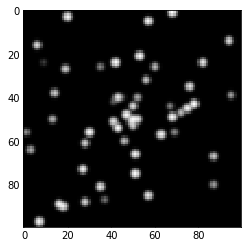

In [14]:
norm = scarlet.display.Asinh(img=np.array([data2,data2,data2]), Q=20)
filter_indices = [0,2,1]
img_rgb = scarlet.display.img_to_rgb(np.array([data2,data2,data2]), filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)


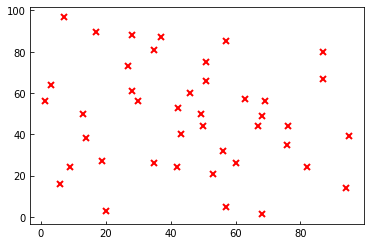

In [15]:
for src in catalog:
    plt.plot(src["x"], src["y"], "rx", mew=2)
plt.show()

In [16]:
images = np.array([data2,data2,data2])

sources = [scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms) for src in catalog]
blend = scarlet.Blend(sources)
blend.set_data(images, bg_rms=bg_rms)
blend.fit(200)
print("scarlet ran for {0} iterations".format(blend.it))


scarlet ran for 200 iterations


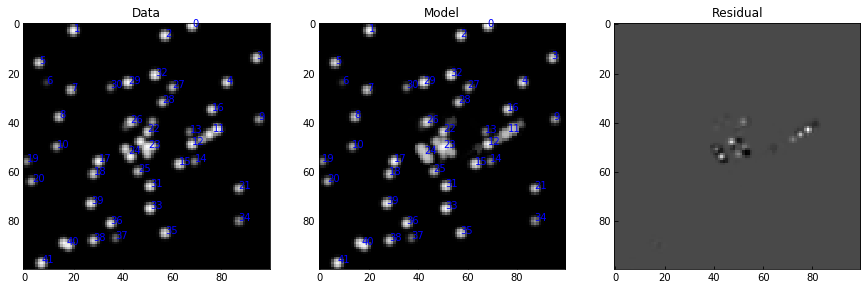

In [17]:
# Load the model and calculate the residual
model = blend.get_model()
residual = images - model
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend.components):
    y,x = component.center
    ax[0].text(x, y, k, color="b")
    ax[1].text(x, y, k, color="b")
plt.show()
